In [1]:
import copra
import matplotlib.pyplot as pl

In [2]:
# get synthetic model measurements
model, dataframes = copra.synthcore(M=10, ae_top=10, ae_bot=500, ae_incr="exp")
age_df, proxy_df = dataframes[0], dataframes[1]

simulate logistic growth of sedimentary archive ...
simulate proxy signal as noisy sinusoid ...
create dictionary for model ...
create DataFrame from dictionary ...
make age measurements ...
make proxy measurements ...
create dictionaries for model and measurements ...
create dataframes from dictionaries ...


In [3]:
# run COPRA
agemods = copra.agemodels(age_df, proxy_df, nens=200, extrapolate=False)
prxens = copra.proxyens(agemods, proxy_df, ageres=20, agelims=(100, 9500), nan_policy="strict")

estimating age models ...
	These values were assigned NaN values.
	Removing times with NaNs as per 'nan_policy = strict'
	Prescribed age limits (BP) = (100.0, 9500.0)
	Final age limits (BP) = (100.0, 8940.0)


In [5]:
# remove time points with NaNs
num_nans = copra.np.isnan(prxens.iloc[:, 1:].to_numpy()).sum(axis=1)
nonan_idx = np.where(num_nans == 0)[0]
prxens = prxens.iloc[nonan_idx]

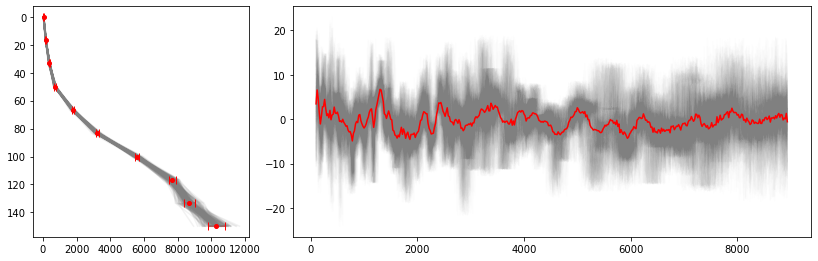

In [6]:
# plot results
fig = pl.figure(figsize=[12., 4.])
ax1 = fig.add_axes([0.05, 0.10, 0.25, 0.80])
ax2 = fig.add_axes([0.35, 0.10, 0.60, 0.80])
ax1.plot(agemods.iloc[:, 1:], agemods['depth'], "-", c="0.5", alpha=0.10)
ax1.errorbar(age_df['age'], age_df['depth'], xerr=age_df['error'], fmt="ro",
             capsize=4, ms=4)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.plot(prxens['age'], prxens.iloc[:, 1:], "-", c="0.5", ms=2, alpha=0.01)
ax2.plot(prxens['age'], prxens.iloc[:, 1:].mean(axis=1), "-", c="r")

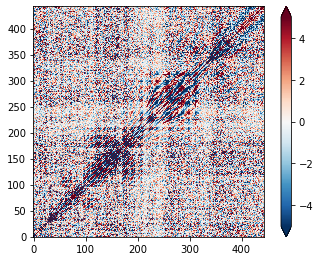

In [7]:
# covariance function
precs = prxens.iloc[:, 1:].to_numpy()
cov = copra.np.cov(precs)

fig = pl.figure()
ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
im = ax.imshow(cov, cmap="RdBu_r", origin="lower", vmin=-5, vmax=5)
pl.colorbar(im, extend="both")

In [8]:
x_star = np.linspace(prxens["age"].to_numpy()[0]-1000, prxens["age"].to_numpy()[-1] + 1001, 1000)
X_star = x_star.reshape(len(x_star), 1)

# get gp
gp = copra.proxygp(prxens)

# sample from the posterior
nsamp = 100
samples = gp.sample_y(X_star, nsamp)

# Make the prediction on test set, i.e. sample posterior mean
y_pred, cov_pred = gp.predict(X_star, return_cov=True)

# get credible intervals
y_bar = samples.mean(axis=1)
y_std = samples.std(axis=1)

(-25, 25)

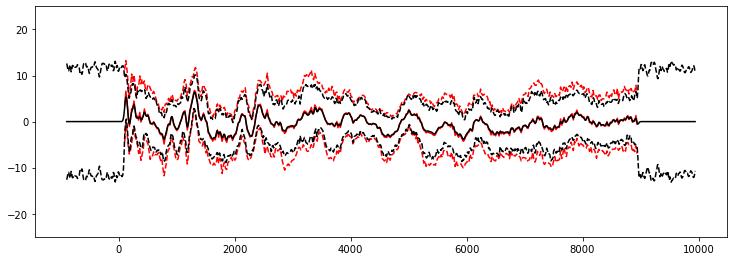

In [9]:
prxs = prxens.iloc[:, 1:].to_numpy()
prx_mean = copra.np.nanmean(prxs, axis=1)
prx_err = copra.np.nanstd(prxs, axis=1)
fig = pl.figure(figsize=[12., 4.])
ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.plot(prxens['age'], prx_mean, "r-")
ax.plot(prxens['age'], prx_mean + prx_err, "r--")
ax.plot(prxens['age'], prx_mean - prx_err, "r--")
ax.plot(X_star, y_pred, "-", c="k")
ax.plot(X_star, y_pred + y_std, "k--")
ax.plot(X_star, y_pred - y_std, "k--")
ax.set_ylim(-25, 25)

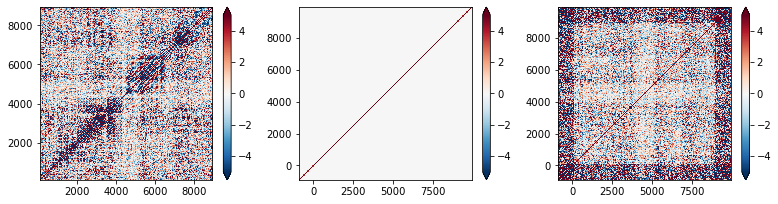

In [17]:
# look at the covariance functions
fig = pl.figure(figsize=[12., 4.])
ax1 = fig.add_axes([0.10, 0.10, 0.25, 0.80])
im1 = ax1.imshow(cov, cmap="RdBu_r", origin="lower", vmin=-5, vmax=5,
                 extent=(prxens["age"][0], prxens["age"][len(prxens) - 1],
                         prxens["age"][0], prxens["age"][len(prxens) - 1])
                )
pl.colorbar(im1, extend="both", shrink=0.75)
ax2 = fig.add_axes([0.40, 0.10, 0.25, 0.80])
im2 = ax2.imshow(cov_pred, cmap="RdBu_r", origin="lower", vmin=-5, vmax=5,
                 extent=(x_star[0], x_star[-1], x_star[0], x_star[-1])
                )
pl.colorbar(im2, extend="both", shrink=0.75)
ax3 = fig.add_axes([0.70, 0.10, 0.25, 0.80])
cov_sample = copra.np.cov(samples)
im3 = ax3.imshow(cov_sample, cmap="RdBu_r", origin="lower", vmin=-5, vmax=5,
                 extent=(x_star[0], x_star[-1], x_star[0], x_star[-1])
                )
pl.colorbar(im3, extend="both", shrink=0.75)